In [40]:
import numpy as np
import geopandas as gpd
import shapely

from explore import *
from utils import *

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as cx

# dados de https://appeears.earthdatacloud.nasa.gov

In [41]:
def 

def evaluate_gpd(reference: gpd.GeoDataFrame, other: gpd.GeoDataFrame,
                 reference_value_column: str = 'value', 
                 other_value_column: str = 'value'):
    """
    | other \ reference | queimada | não queimada |
    |-------------------|----------|--------------|
    |     queimada      |    TP    |      FP      |
    |   não queimada    |    FN    |      TN      |
    |-------------------|----------|--------------|
    """
    
    original_geometry = other['geometry']
    other['geometry'] = other.representative_point()
    join_gpd = gpd.sjoin(reference, other, op="contains", lsuffix='reference', rsuffix='other')
    other['geometry'] = original_geometry
    
    same_names = reference_value_column == other_value_column
    burned_reference = np.array(join_gpd[reference_value_column + ('_reference' if same_names else '')])
    burned_other = np.array(join_gpd[other_value_column + ('_other' if same_names else '')])
    unburned_reference = np.array(1.0 - join_gpd[reference_value_column + ('_reference' if same_names else '')])
    unburned_other = np.array(1.0 - join_gpd[other_value_column + ('_other' if same_names else '')])

    def calculate_same(array1, array2):
        min_array = np.array([array1, array2]).min(axis=0)
        min_array[np.isnan(min_array)] = 0.0
        return min_array.sum()
    
    def calculate_diff(array1, array2):
        temp1 = array1[array1 > array2]
        temp2 = array2[array1 > array2]
        diff = (temp1 - temp2)
        return diff.sum()

    TP = calculate_same(burned_reference, burned_other) # True Positive
    FN = calculate_diff(burned_reference, burned_other) # False Negative
    FP = calculate_diff(burned_other, burned_reference) # False Positive
    TN = calculate_same(unburned_reference, unburned_other) # True Negative

    ACC = (TP + TN) / (TP + FP + FN + TN)
    TPR = TP / (TP + FN) # true positive rate
    TNR = TN / (TN + FP) # true negative rate
    PPV = TP / (TP + FP) # positive predictive value 
    NPV = TN / (TN + FN) # negative predictive value
    OE = FN / (FN + TP) 
    CE = FP / (FP + TP)
    B  = (TP + FP) / (TP + FN) # viés
    DC = 2 * TP / (2 * TP + FP + FN)
    CSI = TP / (TP + FP + FN)

    return { 'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN,
             'ACC': ACC, 'CE': CE, 'OE': OE, 'B': B, 
             'DC': DC, 'TPR': TPR, 'TNR': TNR, 'PPV': PPV, 
             'NPV': NPV, 'CSI': CSI }


In [42]:
def plot_burned_gdf(ax: plt.Axes, gdf: gpd.GeoDataFrame, simple: bool = False):
    geod = Geod(ellps="WGS84")
    positive_normalized = gdf[gdf['value'] > 0]
    if simple:
        positive_normalized.plot(ax=ax, linewidth=0.0)
    else:
        positive_normalized.plot(column='value', ax=ax, cmap='Reds', linewidth=0.0, legend=True)
    area = positive_normalized['geometry'].map(lambda geo: abs(geod.geometry_area_perimeter(geo)[0]))
    reference_burned_area = (area * positive_normalized['value']).sum() / 1000000
    ax.legend(title = "{:.2f}Km²".format(reference_burned_area), loc='lower left')

def compare_aqm_and_explore(aqm_gdf: gpd.GeoDataFrame, explore_df: pd.DataFrame, 
                            xmin = None, xmax = None, ymin = None, ymax = None, 
                            quadrat_width = 0.005, ax1: plt.Axes = None, 
                            ax2: plt.Axes = None, normatized: bool = False):
    if ax1 is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True, sharex=True)
        fig.tight_layout()

    bounds = None if xmin is None else shapely.geometry.box(xmin, ymin, xmax, ymax)
    normalized = aqm_gdf if normatized else normalize_gdf(aqm_gdf, bounds, quadrat_width)
    plot_burned_gdf(ax1, normalized)

    cx.add_basemap(ax1, crs=normalized.crs.to_string())

    data_temp = explore_df if xmin is None else sub_space(explore_df, ymin, ymax, xmin, xmax)
    explorer = SatellitesExplore(data_temp, quadrat_width=quadrat_width, 
                                 burned_area_calc=polinomial_burned_area_calc(1, 10, 2),
                                 min_area_percentage=0.02,
                                 threshold_satellite=1)
    # explorer.show_satellites_areas(ax=ax2)
    explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds')
    cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())

    burned = explorer.get_burned_areas()
    temp = gpd.GeoDataFrame(
        { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
        crs = burned.crs
    )
    evaluate = evaluate_gpd(normalized, temp)
    ax2.set_title(f"""ACC = {int(evaluate['ACC'] * 100)}%, CE = {int(evaluate['CE'] * 100)}%, OE = {int(evaluate['OE'] * 100)}%""")
    return (evaluate, normalized, temp)

In [43]:
def compare_aqm_and_explore_multiple(aqm_gdfs: list[gpd.GeoDataFrame], explore_dfs: list[pd.DataFrame], 
                                     xmin = None, xmax = None, ymin = None, ymax = None, 
                                     quadrat_width = 0.005, normatized: bool = False):
    size = len(aqm_gdfs)
    fig, axs = plt.subplots(size, 2, figsize=(25, size * 10), sharey=True, sharex=True)
    fig.tight_layout()
    for index, (aqm_file, explore_df) in enumerate(zip(aqm_gdfs, explore_dfs)):
        (ax1, ax2) = axs[index]
        data, aqm, explore = compare_aqm_and_explore(aqm_file, explore_df, xmin, xmax, ymin, ymax, 
                                       quadrat_width, ax1, ax2, normatized)
        time = explore_df.iloc[0]['datahora']
        ax1.set_title(f'Time: {time}')

In [186]:
import spatialpandas as spd
import xarray as xr

def create_dataarray(data: gpd.GeoDataFrame, value_column: str = 'value') -> xarray.DataArray:
    temp = data[data[value_column] > 0.0]
    points = temp.representative_point()
    idx = pd.MultiIndex.from_arrays(arrays=[points.y, points.x], names=["y", "x"])
    s = pd.Series(temp[value_column].values, index=idx)
    return xr.DataArray.from_series(s, sparse=False)

def create_gpd(data: xr.DataArray, value_dim: str = 'value') -> gpd.GeoDataFrame:
    frame = data.to_dataframe(name=value_dim).reset_index()
    frame = frame[frame['value'] > 0.0]
    return gpd.GeoDataFrame(
        data=frame['value'], 
        geometry=gpd.points_from_xy(x=frame['x'], y=frame['x']))

In [45]:
df = read_burn_df()

In [9]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdfs = [normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210703_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210719_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210804_0107'), geometry, quadrat_width), 
            normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107'), geometry, quadrat_width)]
explore_dfs = [sub_space_by_landsat(df.query("'2021-06-18 00:00:00-03:00' < datahora < '2021-07-03 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-03 00:00:00-03:00' < datahora < '2021-07-19 23:59:59-03:00'"), path, row),
               sub_space_by_landsat(df.query("'2021-07-19 00:00:00-03:00' < datahora < '2021-08-04 23:59:59-03:00'"), path, row), 
               sub_space_by_landsat(df.query("'2021-08-05 00:00:00-03:00' < datahora < '2021-08-20 23:59:59-03:00'"), path, row)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

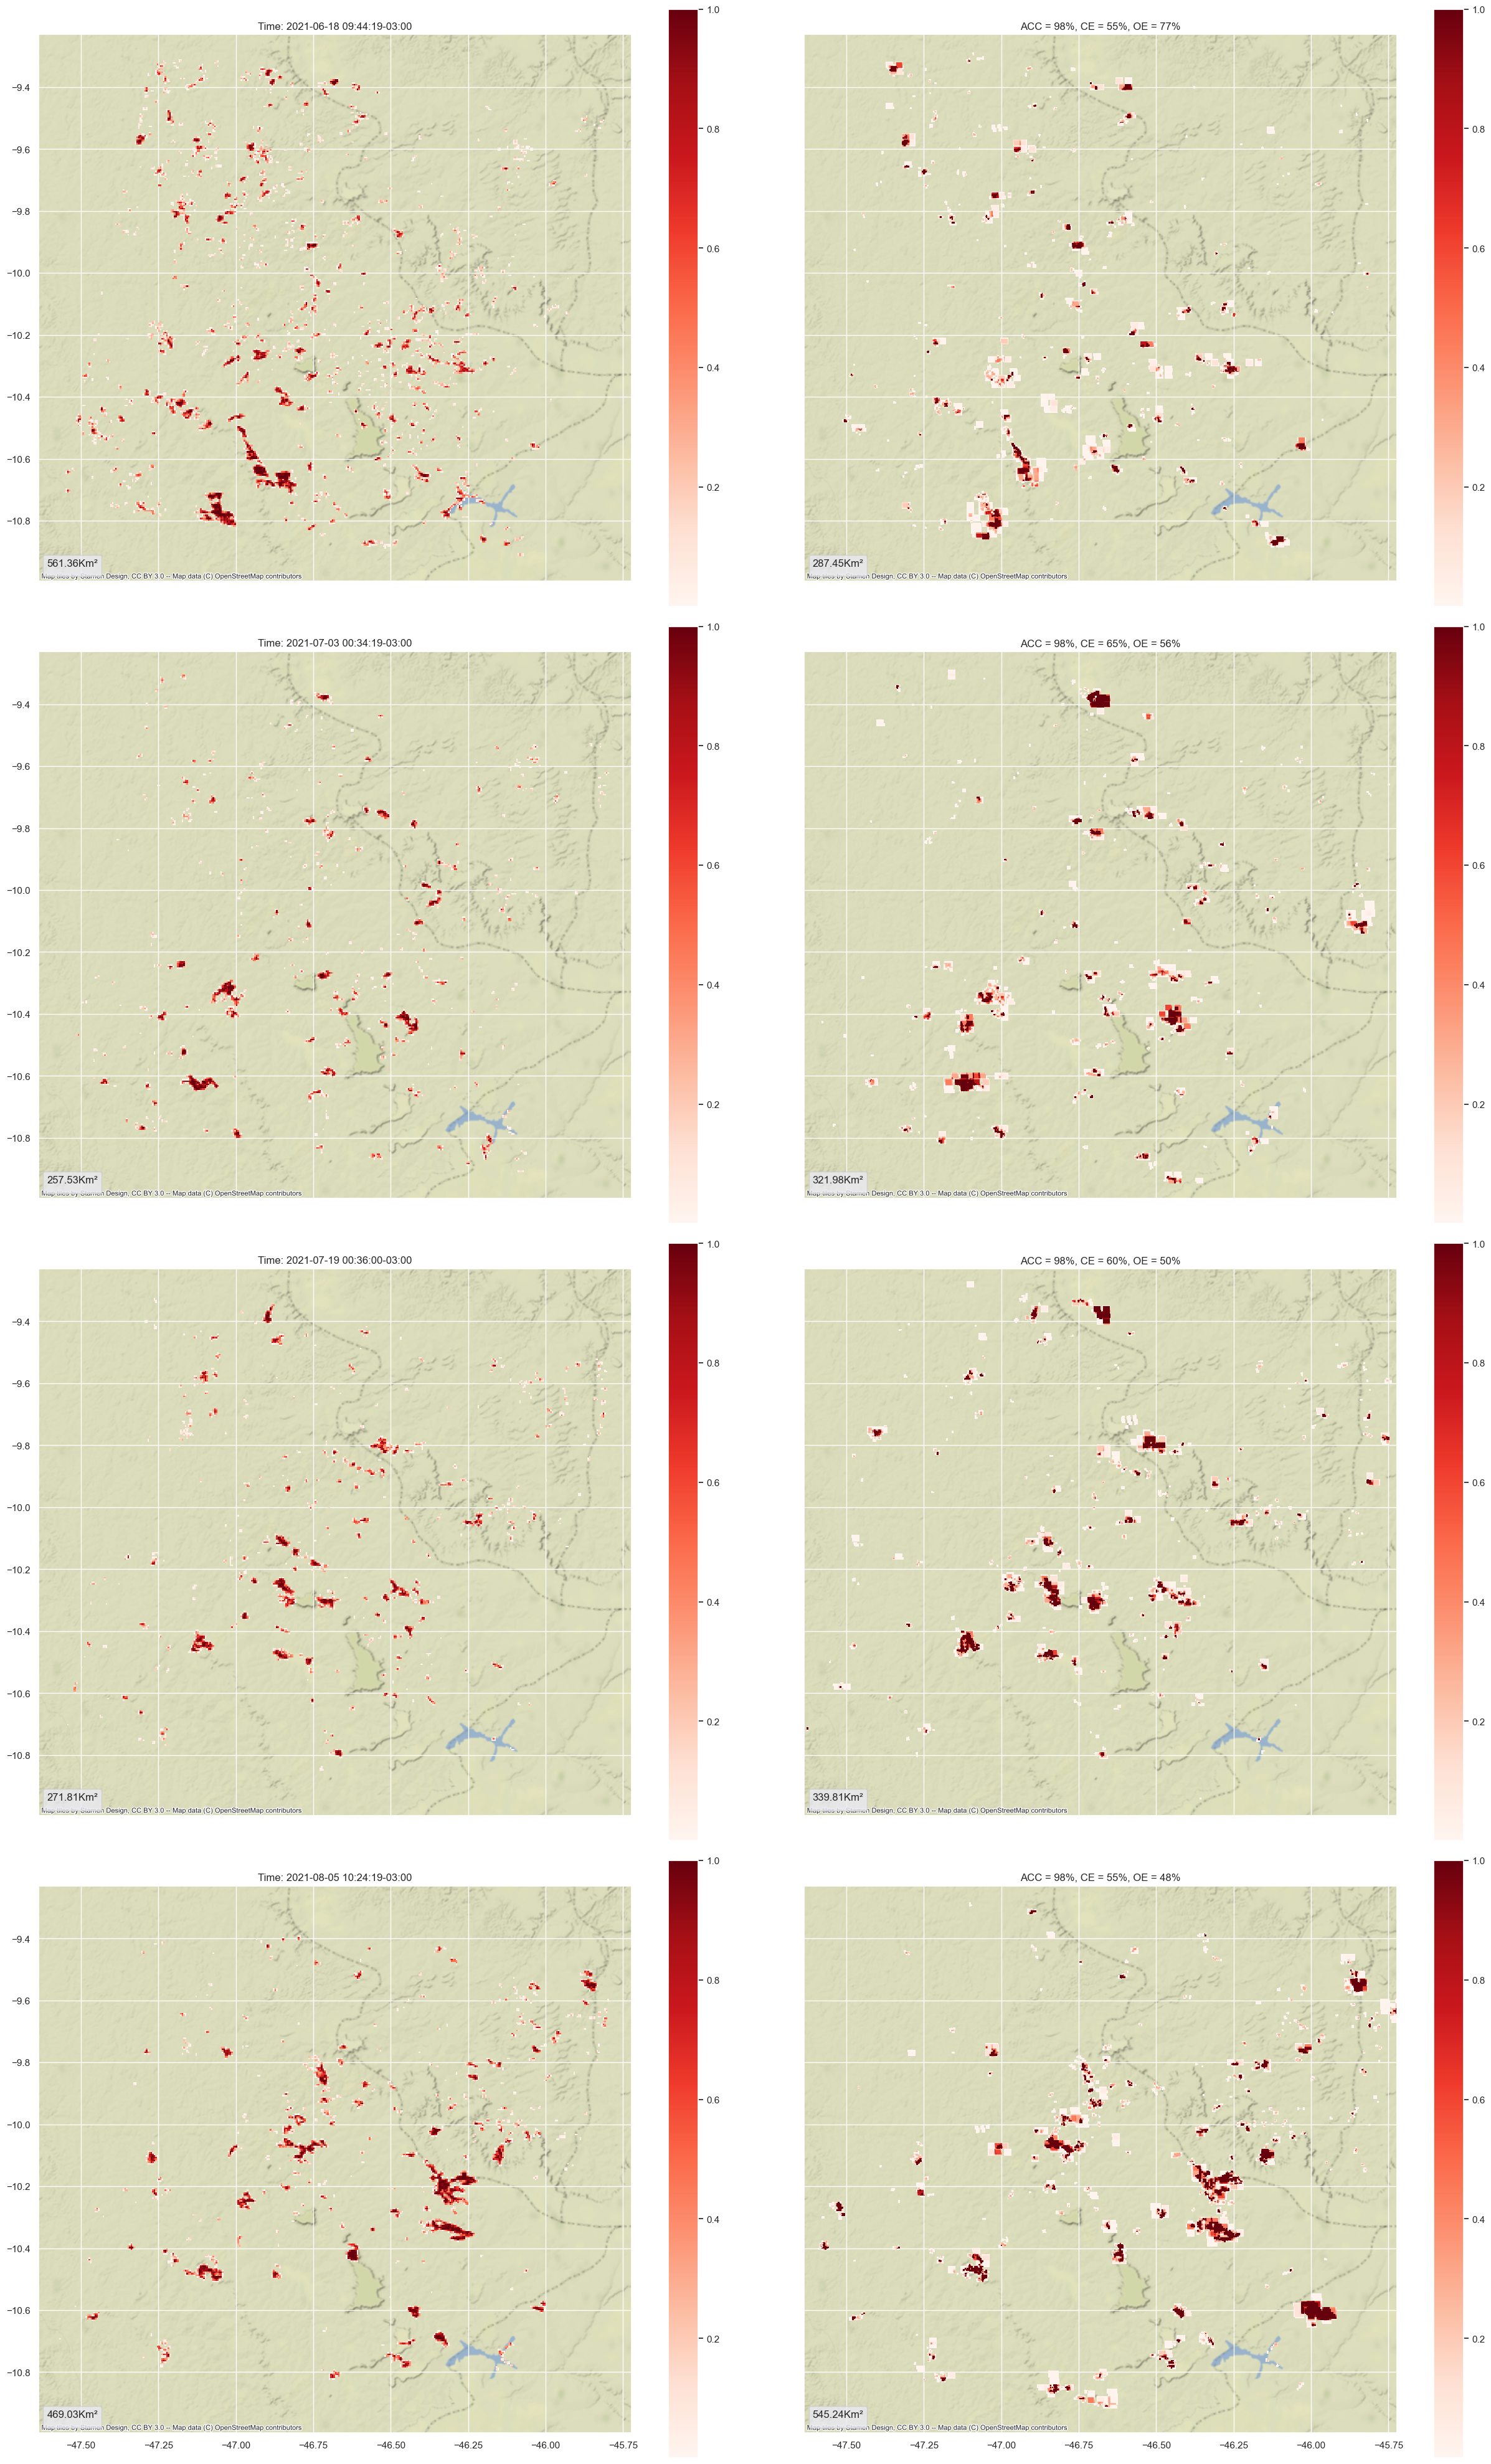

In [108]:
# Validação com o AQ30km
compare_aqm_and_explore_multiple(aqm_gdfs, explore_dfs, quadrat_width=quadrat_width, normatized=True)

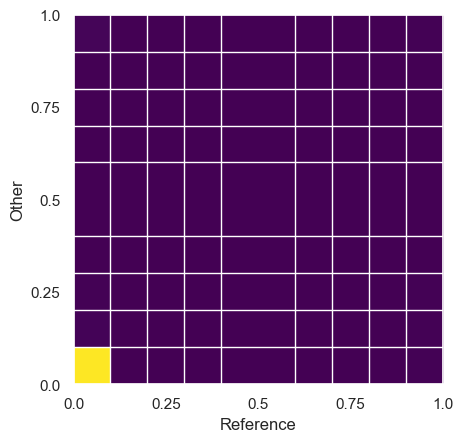

In [13]:

def compare_values(values1: np.array, values2: np.array, n: int = 10, 
                   values1_label: str = 'Other', values2_label: str = 'Reference'):
    bins = np.linspace(0.0, 1.0, n)
    inds1 = np.digitize(values1, bins)
    inds2 = np.digitize(values2, bins)

    count = np.array([[np.min([np.sum(inds1 == i+1), np.sum(inds2 == j+1)]) for j in range(n)] for i in range(n)])

    fig, ax = plt.subplots(1, 1)
    ax.imshow(np.flip(count, 0), cmap='viridis', extent=[0, 1, 0, 1])

    ax.set_xticks(np.linspace(0.0, 1.0, 5))
    ax.set_yticks(np.linspace(0.0, 1.0, 5))
    ax.set_xticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_yticks(np.linspace(0.0, 1.0, n+1), minor=True)
    ax.set_xticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_yticklabels(np.linspace(0.0, 1.0, 5))
    ax.set_ylabel(values1_label)
    ax.set_xlabel(values2_label)

    ax.grid(False)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

values1 = explore['value'].values
values2 = aqm['value'].values
compare_values(values1, values2)


In [224]:
path, row, quadrat_width = 221, 67, 0.005
geometry = get_landsat_geometry(path, row)
aqm_gdf = normalize_gdf(gpd.read_file('tiff/LS8_AQM_221_067_20210703_0107'), geometry, quadrat_width)
explore_df = sub_space_by_landsat(df.query("'2021-06-17 14:00:00-03:00' < datahora < '2021-07-03 14:00:00-03:00'"), path, row)

explorer = SatellitesExplore(explore_df, 
                             delimited_region=geometry,
                             quadrat_width=quadrat_width, 
                             burned_area_calc=polinomial_burned_area_calc(2, 6, 2),
                             min_area_percentage=0.02,
                             threshold_satellite=1)
burned = explorer.get_burned_areas()

temp = gpd.GeoDataFrame(
    { 'value': burned['burned_factor'], 'geometry': burned['geometry'] },
    crs = burned.crs
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True, sharex=True)
fig.tight_layout()

plot_burned_gdf(ax1, aqm_gdf)
cx.add_basemap(ax1, crs=aqm_gdf.crs.to_string())
ax1.plot(*geometry.exterior.xy)
explorer.show_satellites_quads_areas(ax=ax2, linewidth=0, cmap='Reds')
cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
ax2.plot(*geometry.exterior.xy)

evaluate = evaluate_gpd(aqm_gdf, temp)
evaluate

TypeError: __init__() got an unexpected keyword argument 'delimited_region'

In [215]:
len(aqm_gdf['value'])

89987

In [216]:
len(temp['value'])

108438

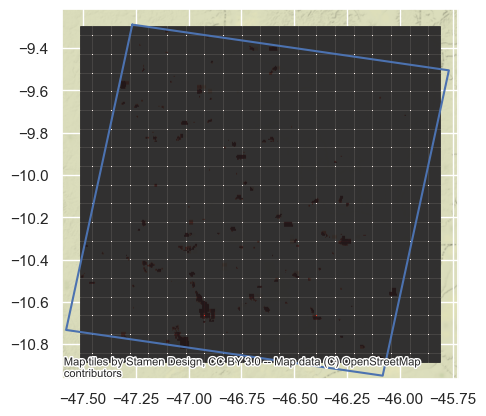

In [220]:
ax2 = plt.gca()
points: gpd.GeoDataFrame = explorer.get_all_evaluated_quads()
points.plot(column='burned_factor', cmap='Reds', ax=ax2, edgecolor='k', linewidth=0.5)
cx.add_basemap(ax2, crs=explorer.dataframe.crs.to_string())
ax2.plot(*geometry.exterior.xy)
# ax.scatter(aqm_gdf['value'], temp['value'])

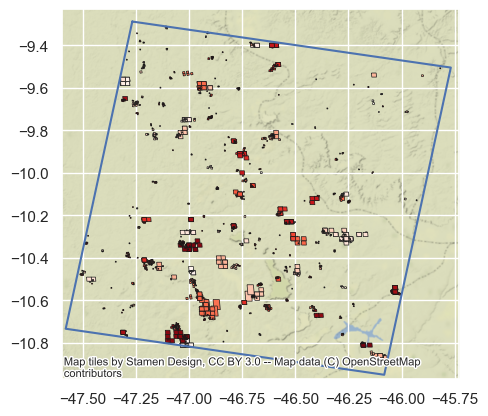

In [222]:
explore_df = sub_space_by_landsat(df.query("'2021-06-17 14:00:00-03:00' < datahora < '2021-07-03 14:00:00-03:00'"), path, row)
satellites_data = SatellitesMeasureGeometry(explore_df)
dataframe = satellites_data.get_satelites_measures_area()

ax2 = plt.gca()
dataframe.plot(cmap='Reds', ax=ax2, edgecolor='k', linewidth=0.5)
cx.add_basemap(ax2, crs=dataframe.crs.to_string())
ax2.plot(*geometry.exterior.xy)

In [57]:
import mapclassify
fj5 = mapclassify.StdMean(burned["value"])
fj5

StdMean

   Interval       Count
-----------------------
( -inf, -2.56] |      0
(-2.56, -1.17] |      0
(-1.17,  1.61] | 105905
( 1.61,  3.00] |   1543
( 3.00, 55.72] |   2354

In [37]:
import mapclassify
import numpy as np

class BurnedAreaCalcWrapper:

    def __init__(self, classifierBuilder, **kargs):
        self.classifierBuilder = classifierBuilder
        self.kargs = kargs
        self.hist = None

    def invoke(self, value: float, values: np.ndarray) -> float:
        if self.hist is None:
            self.hist = self.classifierBuilder(values, **self.kargs)
            self.min_range = self.hist.bins[int(len(self.hist.bins)/2) - 1]
            self.max_range = self.hist.bins[int(len(self.hist.bins)/2)]
            print(self.min_range, self.max_range)
            self.value_range = (self.max_range - self.min_range)
        return min(1, max(0, (value - self.min_range) / self.value_range))


In [217]:
temp_array = create_dataarray(temp)
aqm_array = create_dataarray(aqm_gdf)

In [293]:
temp_array.sel(x=aqm_array.x, method="nearest").sel(y=aqm_array.y, method="nearest")

<xarray.DataArray (y: 316, x: 330)>
<COO: shape=(316, 330), dtype=float64, nnz=5567, fill_value=nan>
Coordinates:
  * y        (y) float64 -10.88 -10.88 -10.88 -10.88 ... -9.322 -9.317 -9.312
  * x        (x) float64 -47.51 -47.51 -47.51 -47.51 ... -45.82 -45.82 -45.81

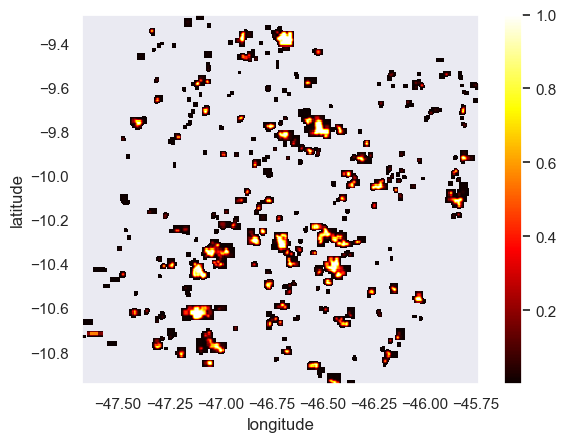

In [197]:
import cv2

dataarray = create_dataarray(explore)
# kernel = np.array([
#     [0   ,1/16, 1/8, 1/16, 0   ],
#     [1/16, 1/8, 1/4, 1/8, 1/16],
#     [1/8 , 1/6, 1/2, 1/6, 1/8 ],
#     [1/16, 1/8, 1/6, 1/8, 1/16],
#     [0   ,1/16, 1/8,1/16, 0   ],
# ])
kernel = np.array([
    [1/16, 1/8, 1/16],
    [1/8,  1/4, 1/8],
    [1/16, 1/8, 1/16],
])
dataarray.data = np.clip(cv2.filter2D(dataarray.fillna(0.0).to_numpy(), -1, kernel), 0.0, 1.0)
dataarray.where(dataarray > 0).plot(cmap='hot')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


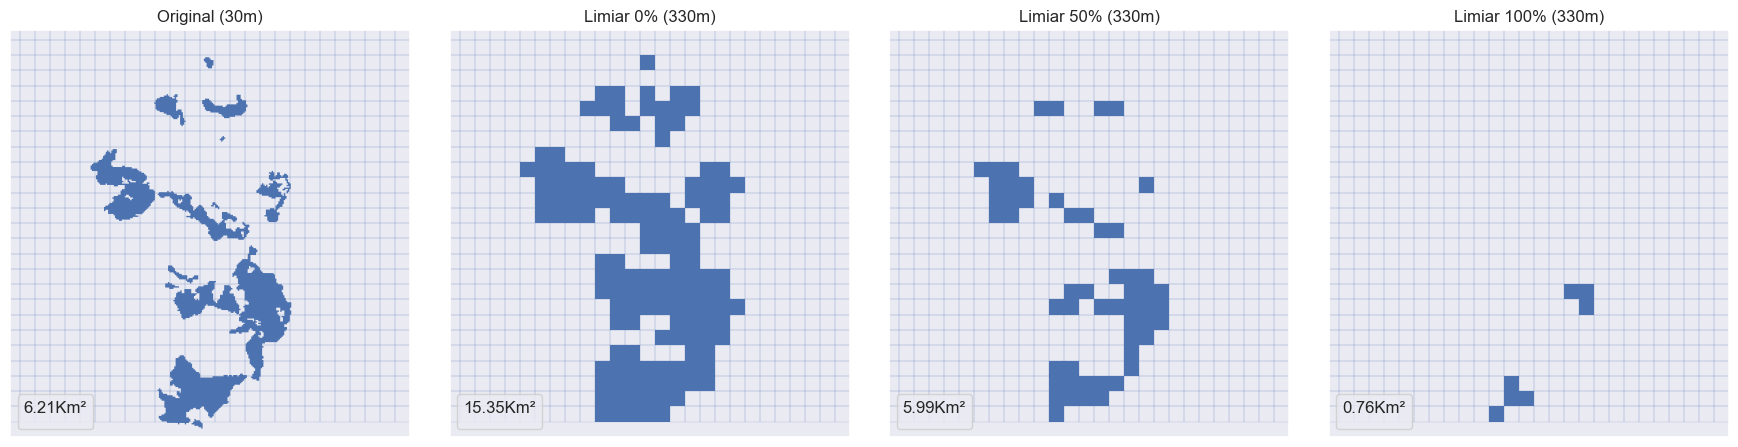

In [152]:
# cmap1 = copy.copy(plt.cm.rainbow)
quadrat_width = 0.003
linewidth = 0.1
geometry = box(-47.27, -10.77, -47.19, -10.69)
xmin, ymin, xmax, ymax = geometry.bounds
geod = Geod(ellps="WGS84")

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

threshold = [0.0, 0.5, 0.9999]

for i, t in enumerate(threshold):
    ax = axs[i+1]
    test = normalize_gdf(aqm30, geometry, quadrat_width)
    test.loc[test['value'] > t, 'value'] = 1
    test.loc[test['value'] <= t, 'value'] = 0
    plot_burned_gdf(ax, test, simple = True)
    test.boundary.plot(ax=ax, linewidth=linewidth)
    new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
    ax.set_title(f"Limiar {round(t * 100)}% ({round(new_resolution)}m)")

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'diferenca_resoluções.pdf'), bbox_inches="tight")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


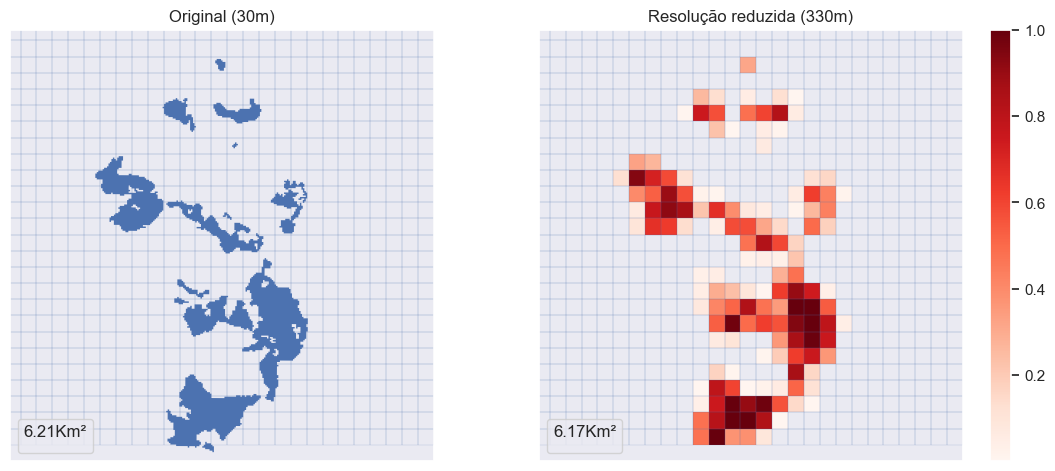

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)
fig.tight_layout()

ax1 = axs[0]
aqm30 = gpd.read_file('tiff/LS8_AQM_221_067_20210820_0107')
aqm30_test = aqm30.cx[xmin:xmax, ymin:ymax]
aqm30_test.plot(ax=ax1, linewidth=0.0)
grid_gdf(aqm30_test, geometry, quadrat_width).boundary.plot(ax=ax1, linewidth=linewidth)
ax1.legend(title = "{:.2f}Km²".format(aqm30_test['km2'].sum()), loc='lower left')
ax1.set_title('Original (30m)')

ax2 = axs[1]
test = normalize_gdf(aqm30, geometry, quadrat_width)
plot_burned_gdf(ax2, test)
test.boundary.plot(ax=ax2, linewidth=linewidth)
new_resolution = geod.geometry_length(test['geometry'].iloc[0]) / 4
ax2.set_title(f'Resolução reduzida ({round(new_resolution)}m)')

for ax in axs.flat:
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    # cx.add_basemap(ax, crs=aqm30.crs.to_string())

fig.savefig(os.path.join(image_folder, 'resolução_continua.pdf'), bbox_inches="tight")